In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, "F:/AI-24-programering/Python-programing-Hannes-Fredriksson/Maskininlärning/Labb/Laboration_2_Film_Recommender/App")

from DataWrangler import MovieData


get_profiles_matrix = MovieData()

In [8]:
tags_data = pd.read_csv("../Data/tags.csv")


In [10]:
# for k in range(100, 200, 10):
#     model = KMeans(n_clusters=k, random_state=42)
#     labels = model.fit_predict(movie_profiles_df[genres]
# )
#     score = silhouette_score(movie_profiles_df[genres], labels)
#     print(f"Clusters: {k}, Silhouette Score: {score}")

In [ ]:
class Recomander():
    
    def __init__(self):
        self.recomandations = None
        self.movie_profiles = get_profiles_matrix.movie_profiles
        self.tf_idf_matrix = get_profiles_matrix.tfidf_matrix
        self.input_movie = None

    def find_input_movie(self, input_movie):
        # Find the movie profile based on title
        movie_profile = self.movie_profiles[self.movie_profiles["title"] == input_movie]
        self.input_movie = movie_profile


    def candidates_model(self):  
        bow_columns = self.movie_profiles.columns[15:]
        input_vector = self.input_movie[bow_columns].values
        similar_movies = self.movie_profiles[self.movie_profiles["movieId"] != self.input_movie["movieId"].values[0]]

        sims = cosine_similarity(input_vector, similar_movies[bow_columns].values)[0]
        similar_movies = similar_movies.copy()
        similar_movies["similarity"] = sims        
        
        candidates = similar_movies.sort_values("similarity", ascending=False).head(60)  
        
        return candidates

    
    def scoring(self):
        candidates = self.candidates_model()
        
        input_tfidf = self.tf_idf_matrix[self.input_movie.index[0]]
        candidates_tfidf = self.tf_idf_matrix[candidates.index]

        sims = cosine_similarity(input_tfidf, candidates_tfidf)[0]
        candidates = candidates.copy()
        candidates["similarity"] = sims

        scoring_set = candidates.sort_values("similarity", ascending=False).head(20)
        return scoring_set
    

  
    def pred_engagement_level(self):        
        feature_list = ["mean_time", "std_time", "last_engagement", 
                    "total_engagement", "release_year_unix", 
                    "since_release_to_mean", "engagement_span"]
        
        X_train, y_train = self.movie_profiles[feature_list], self.movie_profiles["engagement_level"]
        random_forest = RandomForestClassifier(n_estimators=10, random_state=42)
        random_forest.fit(X_train, y_train)

        return random_forest, feature_list
        
        
    def recommander(self):
        scoring_set= self.scoring()
        model, feature_list = self.pred_engagement_level()

        pred = model.predict(scoring_set[feature_list])

        scoring_set["pred_engagement_level"] = pred
        classes = ['Very High', 'High', 'Medium', 'Low', 'Very Low']

        scoring_set["pred_engagement_level"] = scoring_set["pred_engagement_level"].astype('category')


        order = list(set(scoring_set["pred_engagement_level"]) - set(classes)) + classes
        scoring_set["pred_engagement_level"] = scoring_set["pred_engagement_level"].cat.reorder_categories(order)

        high_engamnate = scoring_set.sort_values(by="pred_engagement_level", ascending=True).head(3)
        scoring_set.drop(high_engamnate.index, inplace=True)

        recent_realesed = scoring_set.sort_values(by="year", ascending=False).head(2)
        recommendations = pd.concat([high_engamnate, recent_realesed])
        recommendations.reset_index(drop=True, inplace=True)

        return recommendations

In [129]:
recomander = Recomander()
recomander.find_input_movie("Apocalypse Now")

candi  = recomander.candidates_model()
scoring_set = recomander.scoring()



In [190]:
recomander.movie_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49932 entries, 0 to 49931
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                49932 non-null  int64  
 1   title                  49932 non-null  object 
 2   year                   49932 non-null  object 
 3   genres                 49932 non-null  object 
 4   mean_rating            49932 non-null  float64
 5   total_ratings          49932 non-null  float64
 6   mean_time              49932 non-null  float64
 7   std_time               49932 non-null  float64
 8   last_engagement        49932 non-null  float64
 9   total_engagement       49932 non-null  float64
 10  release_year_unix      49932 non-null  float64
 11  since_release_to_mean  49932 non-null  float64
 12  engagement_span        49932 non-null  float64
 13  engagement_level       49932 non-null  object 
 14  action                 49932 non-null  int64  
 15  ad

In [131]:
feature_list = ["mean_time", "std_time", "last_engagement", 
                "total_engagement", "release_year_unix", 
                "since_release_to_mean", "engagement_span"]
X_train, X_test, y_train, y_test = train_test_split(recomander.movie_profiles[feature_list], recomander.movie_profiles["engagement_level"])


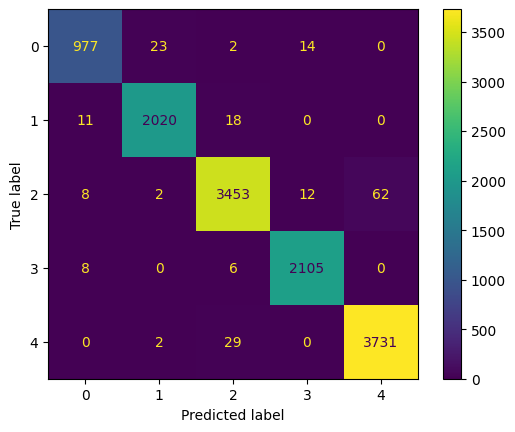

In [187]:
random_forest = RandomForestClassifier(n_estimators=10, random_state=42)

random_forest.fit(X_train, y_train)
pred = random_forest.predict(X_test)
true = scoring_set["engagement_level"]
cm = confusion_matrix(pred, y_test)

disp = ConfusionMatrixDisplay(cm)

disp.plot()

In [188]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

        High       0.97      0.96      0.97      1016
         Low       0.99      0.99      0.99      2049
      Medium       0.98      0.98      0.98      3537
   Very High       0.99      0.99      0.99      2119
    Very Low       0.98      0.99      0.99      3762

    accuracy                           0.98     12483
   macro avg       0.98      0.98      0.98     12483
weighted avg       0.98      0.98      0.98     12483



In [189]:
pred = random_forest.predict(scoring_set[feature_list])

scoring_set["pred_engagement_level"] = pred
random_forest.classes_
classes = ['Very High', 'High', 'Medium', 'Low', 'Very Low']

scoring_set["pred_engagement_level"] = scoring_set["pred_engagement_level"].astype('category')


order = list(set(scoring_set["pred_engagement_level"]) - set(classes)) + classes
scoring_set["pred_engagement_level"] = scoring_set["pred_engagement_level"].cat.reorder_categories(order)

high_engamnate = scoring_set.sort_values(by="pred_engagement_level", ascending=True).head(3)
scoring_set.drop(high_engamnate.index, inplace=True)

recent_realesed = scoring_set.sort_values(by="year", ascending=False).head(2)


ValueError: items in new_categories are not the same as in old categories

In [ ]:
pred

array(['Low', 'Low', 'Very Low', 'Low', 'Medium', 'Very Low', 'Medium',
       'Medium', 'Low', 'Very Low', 'Low', 'Medium', 'High', 'Medium',
       'Medium', 'Very High', 'Low'], dtype=object)

In [ ]:

recommendations = pd.concat([high_engamnate, recent_realesed])
recommendations.reset_index(drop=True, inplace=True)

recommendations

,movieId,title,year,genres,mean_rating,total_ratings,mean_time,std_time,last_engagement,total_engagement,...,musical,mystery,noir,romance,sci,thriller,war,western,similarity,pred_engagement_level
0,2944,"Dirty Dozen, The",1967,Action|Drama|War,3.813371,8683.0,0.352765,0.549559,0.999926,0.068084,...,0,0,0,0,0,0,1,0,0.183457,Very High
1,8540,Back to Bataan,1945,Drama|War,3.014493,69.0,0.459593,0.399327,0.943579,0.000550,...,0,0,0,0,0,0,1,0,0.197633,High
2,27497,"Lost Battalion, The",2001,Action|Drama|War,3.370000,50.0,0.759265,0.382048,0.996988,0.000496,...,0,0,0,0,0,0,1,0,0.190262,Medium
3,212521,Battle of Jangsari,2019,Action|Drama|War,3.000000,4.0,0.883220,0.078782,0.968287,0.000070,...,0,0,0,0,0,0,1,0,0.267893,Very Low
4,174661,Tubelight,2017,Drama|War,1.210526,19.0,0.817314,0.160138,0.977519,0.000147,...,0,0,0,0,0,0,1,0,0.231373,Very Low
